In [1]:
import numpy as np
from tensorflow.keras.models import load_model
import joblib
import pickle 

from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, TextBox, RangeSlider
#%matplotlib qt
#%matplotlib inline
%matplotlib notebook 
# jupyters notebook Befehl zum direkten Anzeigen von Matplotlib Diagrammen
plt.rcParams['figure.figsize'] = (9, 6)
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
colormap={0:'red',1:'green'}
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True 
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.major.size'] = plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = plt.rcParams['ytick.major.width'] = 1.6
plt.rcParams['font.size'] = 12

#loading observations
from PyAstronomy import pyasl
from observation import load_observations
from chi_computations import chi_window,chi_squared,chi_squared_reduced
from para_transform import para_to_parameterin
from rout import adjust_rout

In [2]:
name='single_23_wo_wrongall3' # what network to use
star_name='star_m-only_3' #what network for mass prediction of star
path_data='./data' #where is the downloaded data
#path_data="https://drive.google.com/uc?export=download&id=1vwjufGk_QitLf0yCpJwJwD13DIO4GOaA"

input_file=True

knn_switch=False # using Knn (this is to large for the online version)
Knn_factor=2 #parameter to adjust the uncertainties

observe=True
residual=True
chi_on=True
chi_mode= 'squared' #'DIANA' #'squared_reduced'#  #       
dereddeningdata=False
file_name='SED_to_fit.dat' 
#file_name='SEDobs.dat'

write_parameterin=True

# loading Observations

In [3]:

if observe:
    lam_obs,flux_obs,sig_obs,filer_names,e_bvstart,R_Vstart=load_observations('Example_observation',file_name,dereddening_data=False)
else:
    e_bvstart=0.1
    R_Vstart=3.1

E(B-V)=0.22748
R_V=3.1
Number of datapoints: 107


# loading data

## Loading network 

In [4]:
scaler=joblib.load(f'{path_data}/scaler/{name}_para_scaler.save')
y_scaler=joblib.load(f'{path_data}/scaler/{name}_sed_scaler.save')

C:\Users\tfk1\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [5]:
model_saved=load_model(f'{path_data}/NeuralNets/{name}.h5')

In [6]:
header=np.load(f'{path_data}/header.npy')
header=np.concatenate((header,['incl']),axis=0)
print(header)

['Mstar' 'Lstar' 'Teff' 'fUV' 'pUV' 'amin' 'amax' 'apow' 'a_settle'
 'Mg0.7Fe0.3SiO3[s]' 'amC-Zubko[s]' 'fPAH' 'PAH_charged' 'Mdisk' 'Rin'
 'Rtaper' 'Rout' 'epsilon' 'MCFOST_H0' 'MCFOST_BETA' 'incl']


In [7]:
txt=str()
with open(f'{path_data}/wavelength.out','r') as f:
    lines=f.readlines()
for line in lines[1:]:
    
    txt=txt+line.strip()+' '  
txt=txt[1:-2].split()
wavelength=np.array(txt,'float64')
  

## loading star network

In [8]:
model_star=load_model(f'{path_data}/StarNets/{star_name}.h5')
input_scaler=joblib.load(f'{path_data}/scaler/{star_name}_input_scaler.save')
output_scaler=joblib.load(f'{path_data}/scaler/{star_name}_output_scaler.save')

In [9]:
def calculate_mstar(Teff,Lstar):
    trans_star=input_scaler.transform(np.expand_dims([Teff,Lstar],axis=0))
    pred_star=model_star.predict(trans_star)
    log_mass=output_scaler.inverse_transform(pred_star)[0,0]
    
    return log_mass

## loading Knn

In [10]:

if knn_switch:
    n_neighbors=20
    weights='distance'
    with open(f'{path_data}/Knns/{name}_{n_neighbors}_{weights}', 'br') as file_pi:
        knn=pickle.load(file_pi)
    dat='test'
    mean_sample=np.load(f'{path_data}/Knns/sample_values/{name}_{n_neighbors}_{weights}_{dat}_mean.npy')
    min_sample=np.load(f'{path_data}/Knns/sample_values/{name}_{n_neighbors}_{weights}_{dat}_min.npy')
    max_sample=np.load(f'{path_data}/Knns/sample_values/{name}_{n_neighbors}_{weights}_{dat}_max.npy')

C:\Users\tfk1\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# preparing handling of the data

In [11]:

def transform_parameter(name,val):
    dummy=np.zeros((1,len(header)))
##    if name in name_log:
#        val=np.log10(val)
    pos=np.where(header==name)[0][0]
    dummy[0,pos]=val
    val=scaler.transform(dummy)[0,pos]
    return val,pos

In [12]:
slider_dict={
    'Mstar':{
        'label':r'$log(M_{star}) [M_{sun}]$',
        'lims':[-0.69, 0.39],
        'x0':0.06,
        'priority':1}
        ,
    
    'Teff':{
        'label':r'$log(T_{eff})$',
        'lims':[3.5, 4.0], 
        'x0':3.69,
        'priority':1},
    
    'Lstar':{
        'label':r'$log(L_{star})$',
        'lims':[-1.3, 1.7],
        'x0':0.79,
        'priority':1}, 
    'fUV':{
        'label':r'$log(fUV)$',
        'lims':[-3, -1],
        'x0':-1.57, 
        'priority':1},
    
    'pUV':{
        'label':r'$log(pUV)$',
        'lims':[-0.3, 0.39],
        'x0':-0.02, 
        'priority':1},
    
    'Mdisk':{
        'label':r'$log(Mass_{disk})$',
        'lims':[-5, 0],
        'x0':-1.367, 
        'priority':2},
    
    'incl':{
        'label':r'$incl [Deg]$',
        'lims':[0, 9],
        'x0':2,
        'priority':2},
    
    'Rin':{
        'label':r'$log(R_{in}[AU])$',
        'lims':[-2.00, 2.00], 
        'x0':-1.34,
        'priority':2},
   
     'Rtaper':{
        'label':r'$log(R_{taper}[AU])$',
        'lims':[0.7, 2.5],
         'x0':1.95, 
        'priority':2},
    
    'Rout':{
        'label':r'$log(R_{out}[AU])$',
        'lims':[1.3, 3.14],
        'x0':2.556, 
        'priority':2},
    
    'epsilon':{
        'label':r'$\epsilon$',
        'lims':[0, 2.5],
        'x0':1, 
        'priority':2},
    
    'MCFOST_BETA':{
        'label':r'$\beta$',
        'lims':[0.9, 1.4],
        'x0':1.15, 
        'priority':2},
    
    'MCFOST_H0':{
        'label':'MCFOST_H0[AU]',
        'lims':[3, 35],
        'x0':12, 
        'priority':2},    
    
    'a_settle':{
        'label':r'$log(a_{settle})$',
        'lims':[-5, -1],
        'x0':-3, 
        'priority':3},
    
    'amin':{
        'label':r'$log(a_{min})$',
        'lims':[-3, -1],
        'x0':-1.5, 
        'priority':3},
    
    
    'amax':{
        'label':r'$log(a_{max})$',
        'lims':[2.48, 4],
        'x0':3.6, 
        'priority':3},
    
    'apow':{
        'label':r'$a_{pow}$',
        'lims':[3, 5],
        'x0':3.6, 
        'priority':3},
    
    'Mg0.7Fe0.3SiO3[s]':{
        'label':r'Mg0.7Fe0.3SiO3[s]',
        'lims':[0.45, 0.7],
        'x0':0.57, 
        'priority':3},
    
    'amC-Zubko[s]':{
        'label':r'amC-Zubko[s]',
        'lims':[0.05, 0.3],
        'x0':0.18, 
        'priority':3},
    
    'fPAH':{
        'label':r'$log(fPAH)$',
        'lims':[-3.5, 0],
        'x0':-1.5, 
        'priority':3},
    
    'PAH_charged':{
        'label':r'PAH_charged',
        'lims':[0, 1], 
        'priority':3},
}

In [13]:
log_dict={'Mstar': 'log', 'Lstar': 'log', 'Teff': 'log', 'fUV': 'log', 'pUV': 'log', 'amin': 'log', 'amax': 'log',
          'apow': 'linear', 'a_settle': 'log', 'Mg0.7Fe0.3SiO3[s]': 'linear', 'amC-Zubko[s]': 'linear', 'fPAH': 'log',
       'PAH_charged': 'linear', 'Mdisk': 'log', 'Rin': 'log', 'Rtaper': 'log', 'Rout': 'log', 'epsilon': 'linear',
       'MCFOST_H0': 'linear', 'MCFOST_BETA': 'linear', 'incl': 'linear'}#,'Dist[pc]':'linear'}

In [14]:
for key in log_dict:
    slider_dict[key]['scale']=log_dict[key]

In [15]:
for key in slider_dict:
    if slider_dict[key]['scale']=='log':
        if 'log' in slider_dict[key]['label']:
            print(slider_dict[key]['label']+': fine')
        else:
            slider_dict[key]['label']='$log('+slider_dict[key]['label'][1:-1]+')$'
            low=slider_dict[key]['lims'][0]
            high=slider_dict[key]['lims'][1]
            slider_dict[key]['lims']=[np.log10(low),np.log10(high)]            

$log(M_{star}) [M_{sun}]$: fine
$log(T_{eff})$: fine
$log(L_{star})$: fine
$log(fUV)$: fine
$log(pUV)$: fine
$log(Mass_{disk})$: fine
$log(R_{in}[AU])$: fine
$log(R_{taper}[AU])$: fine
$log(R_{out}[AU])$: fine
$log(a_{settle})$: fine
$log(a_{min})$: fine
$log(a_{max})$: fine
$log(fPAH)$: fine


In [16]:
for key in slider_dict:
    [down,up]=slider_dict[key]['lims']
    try:
        middle=slider_dict[key]['x0']
        #print('Found')
        #print(middle)
    except:
        middle=(up-down)/2+down
    if slider_dict[key]['scale']=='log':
        middle=10**middle
    print(f'%12.6e {key}'%middle)

1.148154e+00 Mstar
4.897788e+03 Teff
6.165950e+00 Lstar
2.691535e-02 fUV
9.549926e-01 pUV
4.295364e-02 Mdisk
2.000000e+00 incl
4.570882e-02 Rin
8.912509e+01 Rtaper
3.597493e+02 Rout
1.000000e+00 epsilon
1.150000e+00 MCFOST_BETA
1.200000e+01 MCFOST_H0
1.000000e-03 a_settle
3.162278e-02 amin
3.981072e+03 amax
3.600000e+00 apow
5.700000e-01 Mg0.7Fe0.3SiO3[s]
1.800000e-01 amC-Zubko[s]
3.162278e-02 fPAH
5.000000e-01 PAH_charged


In [17]:
dist_start=100
if input_file:
    with open('Para.in','r') as f:
        lines=f.readlines()
        for line in lines:
            split_line=line.split()
            value=float(split_line[0])
            parameter=split_line[1]
            if parameter in slider_dict.keys():
                if parameter=='incl':
                    value=value/10
                if slider_dict[parameter]['scale']=='log':
                    value=np.log10(value)
                slider_dict[parameter]['x0']=value
                
            else:
                if parameter=='Dist[pc]':
                    dist_start=value
                if parameter=='E(B-V)':
                    e_bvstart=value
                    
                if parameter=='R(V)':
                    R_Vstart=value

# plotting

In [18]:
def change_range(ar_val):
    ax.set_xlim(10**(ar_val))
    if residual:
        ax_res.set_xlim(10**ar_val)
def change_flux(ar_val):
    ax.set_ylim(10**(ar_val))
        

def change_dist(dist,data):
    new_data=data*(100/dist)**2
    return new_data
    
def reddening( lam,flux, e_bv, R_V):
        # lam in mu m 
        fluxRed = pyasl.unred(lam*10**4, flux, ebv=-e_bv, R_V=R_V)
        return fluxRed
def update(val):
    #features=np.zeros((1,len(header)))
    for key in slider_dict:
        value=slider_dict[key]['slider'].val
        val_trans, pos=transform_parameter(key,value)
        #print(key,val_transans)
        features[0,pos]=val_trans
        #print(key)
    #print(features)
    data=10**(y_scaler.inverse_transform(model_saved.predict(features)))[0]
    #change distance
    dist=dist_slider.val
    data=change_dist(dist,data)
    if not dereddeningdata:
        #reddening
        e_bv=ebv_slider.val
        R_V=rv_slider.val
        data=reddening(wavelength,data,e_bv,R_V)
    
    if knn_switch:  
        dist,neighbor_ar=knn.kneighbors(features)
        min_dist,mean_dist,max_dist=np.min(dist)/min_sample,np.mean(dist)/mean_sample,np.max(dist)/max_sample
        txt=''
        if mean_dist<=1.0:
            colortitle='tab:green'
        elif 1.0<=mean_dist<=2.0:
            colortitle='tab:orange'
        elif 2.0<=mean_dist:
            colortitle='tab:red'
            txt='Warning!! Few models! '
        ax.set_title(txt+'Distance to neighbors (average=1): Minimum %4.2f, Mean %4.2f, Maximum %4.2f' %(min_dist,mean_dist,max_dist),color=colortitle,fontsize=12)
        
        lower.set_ydata(10**(np.log10(data)-Knn_factor*error_knn[0]))
        higher.set_ydata(10**(np.log10(data)+Knn_factor*error_knn[0]))
    l.set_ydata(data)    
    fig.canvas.draw_idle()
    if residual:
        interp_flux=spline(wavelength,data,lam_obs)
        diff=np.log10(interp_flux)-np.log10(flux_obs)
        res.set_ydata(diff)
        max_diff=1.2*max(abs(np.min(diff)),abs(np.max(diff)))
        ax_res.set_ylim([-max_diff,max_diff])
        if chi_on:
            if chi_mode=='DIANA':
                chi=chi_window(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r'DIANA $\chi$ = %8.4f' %chi,fontsize=12)
            elif chi_mode=='squared':
                chi=chi_squared(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r'$\chi^2$ = %8.4f' %chi,fontsize=12)
            if chi_mode=='squared_reduced':
                chi=chi_squared_reduced(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r' reduced $\chi^2$ = %8.4f' %chi,fontsize=12)

def update_amc(val):
    #features=np.zeros((1,len(header)))
    
    for key in slider_dict:
        if key=='Mg0.7Fe0.3SiO3[s]':
            val_amc=slider_dict['amC-Zubko[s]']['slider'].val
            slider_dict['Mg0.7Fe0.3SiO3[s]']['slider'].eventson= False
            slider_dict['Mg0.7Fe0.3SiO3[s]']['slider'].set_val(0.75-val_amc)
            slider_dict['Mg0.7Fe0.3SiO3[s]']['slider'].eventson= True
        val=slider_dict[key]['slider'].val
        val_trans, pos=transform_parameter(key,val)
        #print(key,val_transans)
        features[0,pos]=val_trans
 
    data=10**(y_scaler.inverse_transform(model_saved.predict(features)))[0]
    dist=dist_slider.val
    data=change_dist(dist,data)
    if not dereddeningdata:
        #reddening
        e_bv=ebv_slider.val
        R_V=rv_slider.val
        data=reddening(wavelength,data,e_bv,R_V)
    
    if knn_switch:  
        dist,neighbor_ar=knn.kneighbors(features)
        min_dist,mean_dist,max_dist=np.min(dist)/min_sample,np.mean(dist)/mean_sample,np.max(dist)/max_sample
        txt=''
        if mean_dist<=1.0:
            colortitle='tab:green'
        elif 1.0<=mean_dist<=2.0:
            colortitle='tab:orange'
        elif 2.0<=mean_dist:
            colortitle='tab:red'
            txt='Warning!! Few models! '
        ax.set_title(txt+'Distance to neighbors (average=1): Minimum %4.2f, Mean %4.2f, Maximum %4.2f' %(min_dist,mean_dist,max_dist),color=colortitle,fontsize=12)
        
        lower.set_ydata(10**(np.log10(data)-Knn_factor*error_knn[0]))
        higher.set_ydata(10**(np.log10(data)+Knn_factor*error_knn[0]))
    l.set_ydata(data)    
    fig.canvas.draw_idle()
    if residual:
        interp_flux=spline(wavelength,data,lam_obs)
        diff=np.log10(interp_flux)-np.log10(flux_obs)
        res.set_ydata(diff)
        max_diff=1.2*max(abs(np.min(diff)),abs(np.max(diff)))
        ax_res.set_ylim([-max_diff,max_diff])
        if chi_on:
            if chi_mode=='DIANA':
                chi=chi_window(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r'DIANA $\chi$ = %8.4f' %chi,fontsize=12)
            elif chi_mode=='squared':
                chi=chi_squared(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r'$\chi^2$ = %8.4f' %chi,fontsize=12)
            if chi_mode=='squared_reduced':
                chi=chi_squared_reduced(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r' reduced $\chi^2$ = %8.4f' %chi,fontsize=12)
def update_sio(val):
    #features=np.zeros((1,len(header)))
    for key in slider_dict:
        if key=='amC-Zubko[s]':
            val_amc=slider_dict['Mg0.7Fe0.3SiO3[s]']['slider'].val
            slider_dict['amC-Zubko[s]']['slider'].eventson= False
            slider_dict['amC-Zubko[s]']['slider'].set_val(0.75-val_amc)
            slider_dict['amC-Zubko[s]']['slider'].eventson= True
        val=slider_dict[key]['slider'].val
        val_trans, pos=transform_parameter(key,val)
        #print(key,val_transans)
        features[0,pos]=val_trans
 
    data=10**(y_scaler.inverse_transform(model_saved.predict(features)))[0]
    dist=dist_slider.val
    data=change_dist(dist,data)
    if not dereddeningdata:
        #reddening
        e_bv=ebv_slider.val
        R_V=rv_slider.val
        data=reddening(wavelength,data,e_bv,R_V)
    
    if knn_switch:  
        dist,neighbor_ar=knn.kneighbors(features)
        min_dist,mean_dist,max_dist=np.min(dist)/min_sample,np.mean(dist)/mean_sample,np.max(dist)/max_sample
        txt=''
        if mean_dist<=1.0:
            colortitle='tab:green'
        elif 1.0<=mean_dist<=2.0:
            colortitle='tab:orange'
        elif 2.0<=mean_dist:
            colortitle='tab:red'
            txt='Warning!! Few models! '
        ax.set_title(txt+'Distance to neighbors (average=1): Minimum %4.2f, Mean %4.2f, Maximum %4.2f' %(min_dist,mean_dist,max_dist),color=colortitle,fontsize=12)
        
        lower.set_ydata(10**(np.log10(data)-Knn_factor*error_knn[0]))
        higher.set_ydata(10**(np.log10(data)+Knn_factor*error_knn[0]))
    l.set_ydata(data)    
    fig.canvas.draw_idle()
    if residual:
        interp_flux=spline(wavelength,data,lam_obs)
        diff=np.log10(interp_flux)-np.log10(flux_obs)
        res.set_ydata(diff)
        max_diff=1.2*max(abs(np.min(diff)),abs(np.max(diff)))
        ax_res.set_ylim([-max_diff,max_diff])
        if chi_on:
            if chi_mode=='DIANA':
                chi=chi_window(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r'DIANA $\chi$ = %8.4f' %chi,fontsize=12)
            elif chi_mode=='squared':
                chi=chi_squared(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r'$\chi^2$ = %8.4f' %chi,fontsize=12)
            if chi_mode=='squared_reduced':
                chi=chi_squared_reduced(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r' reduced $\chi^2$ = %8.4f' %chi,fontsize=12)
def update_rtaper(val):
    #features=np.zeros((1,len(header)))
    for key in slider_dict:
        if key=='Rout':
            val_taper=slider_dict['Rtaper']['slider'].val
            slider_dict['Rout']['slider'].eventson= False
            slider_dict['Rout']['slider'].set_val(np.log10(4*10**val_taper))
            slider_dict['Rout']['slider'].eventson= True
        val=slider_dict[key]['slider'].val
        val_trans, pos=transform_parameter(key,val)
        #print(key,val_transans)
        features[0,pos]=val_trans
 
    data=10**(y_scaler.inverse_transform(model_saved.predict(features)))[0]
    dist=dist_slider.val
    data=change_dist(dist,data)
    if not dereddeningdata:
        #reddening
        e_bv=ebv_slider.val
        R_V=rv_slider.val
        data=reddening(wavelength,data,e_bv,R_V)
    
    if knn_switch:  
        dist,neighbor_ar=knn.kneighbors(features)
        min_dist,mean_dist,max_dist=np.min(dist)/min_sample,np.mean(dist)/mean_sample,np.max(dist)/max_sample
        txt=''
        if mean_dist<=1.0:
            colortitle='tab:green'
        elif 1.0<=mean_dist<=2.0:
            colortitle='tab:orange'
        elif 2.0<=mean_dist:
            colortitle='tab:red'
            txt='Warning!! Few models! '
        ax.set_title(txt+'Distance to neighbors (average=1): Minimum %4.2f, Mean %4.2f, Maximum %4.2f' %(min_dist,mean_dist,max_dist),color=colortitle,fontsize=12)
        
        lower.set_ydata(10**(np.log10(data)-Knn_factor*error_knn[0]))
        higher.set_ydata(10**(np.log10(data)+Knn_factor*error_knn[0]))
    l.set_ydata(data)    
    fig.canvas.draw_idle()
    if residual:
        interp_flux=spline(wavelength,data,lam_obs)
        diff=np.log10(interp_flux)-np.log10(flux_obs)
        res.set_ydata(diff)
        max_diff=1.2*max(abs(np.min(diff)),abs(np.max(diff)))
        ax_res.set_ylim([-max_diff,max_diff])
        
        if chi_on:
            if chi_mode=='DIANA':
                chi=chi_window(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r'DIANA $\chi$ = %8.4f' %chi,fontsize=12)
            elif chi_mode=='squared':
                chi=chi_squared(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r'$\chi^2$ = %8.4f' %chi,fontsize=12)
            if chi_mode=='squared_reduced':
                chi=chi_squared_reduced(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r' reduced $\chi^2$ = %8.4f' %chi,fontsize=12)
def update_rout(val):
    #features=np.zeros((1,len(header)))
    for key in slider_dict:
        if key=='Rtaper':
            val_out=slider_dict['Rout']['slider'].val
            slider_dict['Rtaper']['slider'].eventson= False
            slider_dict['Rtaper']['slider'].set_val(np.log10(10**(val_out)/4))
            slider_dict['Rtaper']['slider'].eventson= True
        val=slider_dict[key]['slider'].val
        val_trans, pos=transform_parameter(key,val)
        #print(key,val_transans)
        features[0,pos]=val_trans
 
    data=10**(y_scaler.inverse_transform(model_saved.predict(features)))[0]
    dist=dist_slider.val
    data=change_dist(dist,data)
    if not dereddeningdata:
        #reddening
        e_bv=ebv_slider.val
        R_V=rv_slider.val
        data=reddening(wavelength,data,e_bv,R_V)
    
    if knn_switch:  
        dist,neighbor_ar=knn.kneighbors(features)
        min_dist,mean_dist,max_dist=np.min(dist)/min_sample,np.mean(dist)/mean_sample,np.max(dist)/max_sample
        txt=''
        if mean_dist<=1.0:
            colortitle='tab:green'
        elif 1.0<=mean_dist<=2.0:
            colortitle='tab:orange'
        elif 2.0<=mean_dist:
            colortitle='tab:red'
            txt='Warning!! Few models! '
        ax.set_title(txt+'Distance to neighbors (average=1): Minimum %4.2f, Mean %4.2f, Maximum %4.2f' %(min_dist,mean_dist,max_dist),color=colortitle,fontsize=12)
        
        lower.set_ydata(10**(np.log10(data)-Knn_factor*error_knn[0]))
        higher.set_ydata(10**(np.log10(data)+Knn_factor*error_knn[0]))
    l.set_ydata(data)    
    fig.canvas.draw_idle()
    if residual:
        interp_flux=spline(wavelength,data,lam_obs)
        diff=np.log10(interp_flux)-np.log10(flux_obs)
        res.set_ydata(diff)
        max_diff=1.2*max(abs(np.min(diff)),abs(np.max(diff)))
        ax_res.set_ylim([-max_diff,max_diff])
        if chi_on:
            if chi_mode=='DIANA':
                chi=chi_window(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r'DIANA $\chi$ = %8.4f' %chi,fontsize=12)
            elif chi_mode=='squared':
                chi=chi_squared(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r' $\chi^2$ = %8.4f' %chi,fontsize=12)
            if chi_mode=='squared_reduced':
                chi=chi_squared_reduced(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r' reduced $\chi^2$ = %8.4f' %chi,fontsize=12)
def update_star(val):
    #features=np.zeros((1,len(header)))
    for key in slider_dict:
        if key=='Teff':
            val_Teff=slider_dict['Teff']['slider'].val
            val_Lstar=slider_dict['Lstar']['slider'].val
            val_mstar=calculate_mstar(val_Teff,val_Lstar)
            slider_dict['Mstar']['slider'].eventson= False
            slider_dict['Mstar']['slider'].set_val(val_mstar)
            slider_dict['Mstar']['slider'].eventson= True
        val=slider_dict[key]['slider'].val
        val_trans, pos=transform_parameter(key,val)
        #print(key,val_transans)
        features[0,pos]=val_trans
 
    data=10**(y_scaler.inverse_transform(model_saved.predict(features)))[0]
    dist=dist_slider.val
    data=change_dist(dist,data)
    if not dereddeningdata:
        #reddening
        e_bv=ebv_slider.val
        R_V=rv_slider.val
        data=reddening(wavelength,data,e_bv,R_V)
    
    if knn_switch:  
        dist,neighbor_ar=knn.kneighbors(features)
        min_dist,mean_dist,max_dist=np.min(dist)/min_sample,np.mean(dist)/mean_sample,np.max(dist)/max_sample
        txt=''
        if mean_dist<=1.0:
            colortitle='tab:green'
        elif 1.0<=mean_dist<=2.0:
            colortitle='tab:orange'
        elif 2.0<=mean_dist:
            colortitle='tab:red'
            txt='Warning!! Few models! '
        ax.set_title(txt+'Distance to neighbors (average=1): Minimum %4.2f, Mean %4.2f, Maximum %4.2f' %(min_dist,mean_dist,max_dist),color=colortitle,fontsize=12)
        
        lower.set_ydata(10**(np.log10(data)-Knn_factor*error_knn[0]))
        higher.set_ydata(10**(np.log10(data)+Knn_factor*error_knn[0]))
    l.set_ydata(data)    
    fig.canvas.draw_idle()
    if residual:
        interp_flux=spline(wavelength,data,lam_obs)
        diff=np.log10(interp_flux)-np.log10(flux_obs)
        res.set_ydata(diff)
        max_diff=1.2*max(abs(np.min(diff)),abs(np.max(diff)))
        ax_res.set_ylim([-max_diff,max_diff])

        if chi_on:
            if chi_mode=='DIANA':
                chi=chi_window(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r'DIANA $\chi$ = %8.4f' %chi,fontsize=12)
            elif chi_mode=='squared':
                chi=chi_squared(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r' $\chi^2$ = %8.4f' %chi,fontsize=12)
            if chi_mode=='squared_reduced':
                chi=chi_squared_reduced(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r' reduced $\chi^2$ = %8.4f' %chi,fontsize=12)
        
def importing(event):
    with open('Para.in','r') as f:
        lines=f.readlines()
        for line in lines:
            split_line=line.split()
            value=float(split_line[0])
            parameter=split_line[1]
            if parameter in slider_dict.keys():
                if parameter=='incl':
                    value=value/10
                if log_dict[parameter]=='log':
                    value=np.log10(value)
                slider_dict[parameter]['slider'].set_val(value)
            else:
                if parameter=='Dist[pc]':
                    dist_slider.set_val(value)
                if parameter=='E(B-V)':
                        ebv_slider.set_val(value)
                if parameter=='R(V)':
                        rv_slider.set_val(value)
            
def exporting(event):
    with open('Para.out','w') as f:
        for key in slider_dict:
                
            value=slider_dict[key]['slider'].val
            if key=='incl':
                value=10*value
            if log_dict[key]=='log':
                value=10**value
            f.write(f'%12.6e {key}\n'%value)
        value=dist_slider.val
        f.write(f'%12.4f Dist[pc]\n'%value)
        value=ebv_slider.val
        f.write(f'%12.4f E(B-V)\n'%value)
        value=rv_slider.val
        f.write(f'%12.4f R(V)\n'%value)
    if write_parameterin:
        para_to_parameterin('Para.out','Parameter.in')
def reset(event):
    for key in slider_dict:
        slider_dict[key]['slider'].reset()
    dist_slider.reset()
    
    if not dereddeningdata:
        e_bv=ebv_slider.reset()
        R_V=rv_slider.reset()
    
    #flux_slider.reset()
    #lam_slider.reset()

def spline(lam,nuflux,new_lam):

    #interpolation on a double logarithmic scale
    s=interpolate.InterpolatedUnivariateSpline(np.log10(lam),np.log10(nuflux))
    interp=10**(s(np.log10(new_lam)))
#    return interp #returning the nex SED
    return interp #for visualisation

<IPython.core.display.Javascript object>


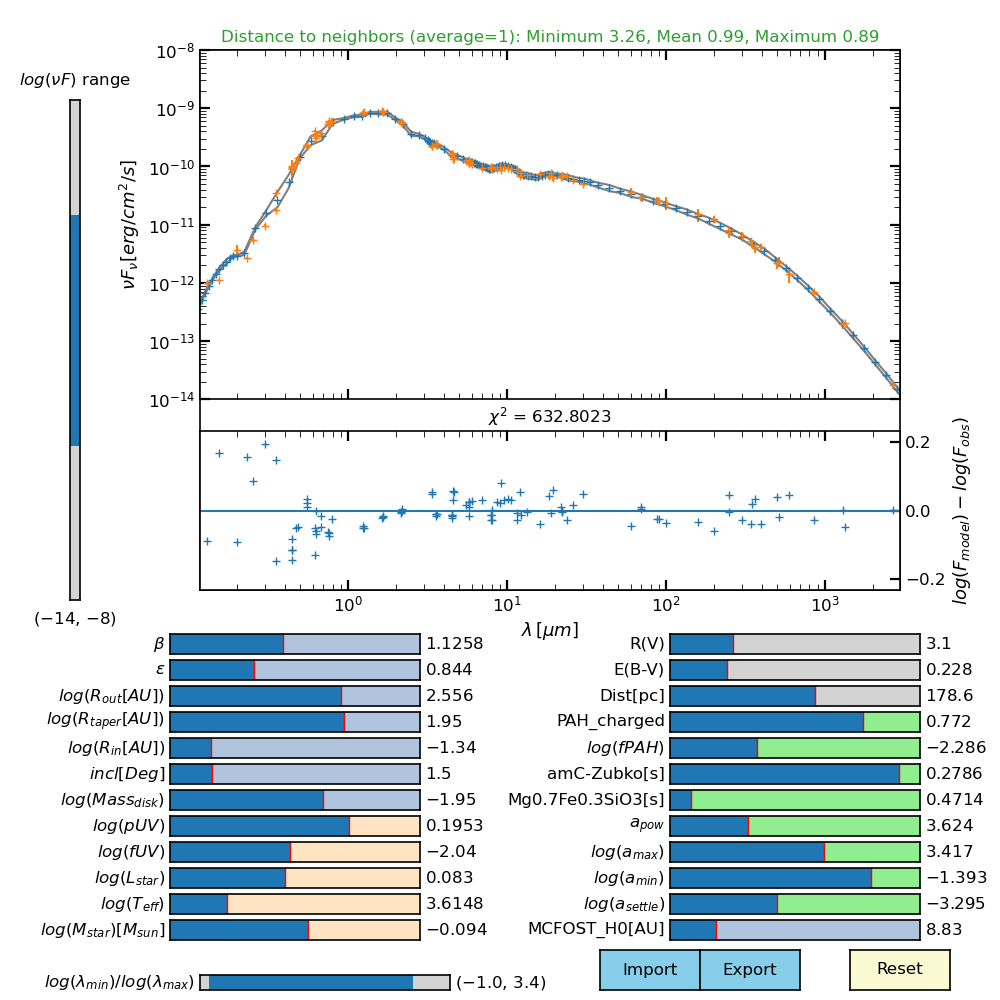

In [21]:
color_list=['bisque','lightsteelblue', 'lightgreen','lightgoldenrodyellow','skyblue','lightgrey']

if observe and residual:
    fig, fig_ax = plt.subplots(figsize=(10,10))
    gs = fig.add_gridspec(3, 1)
    ax = fig.add_subplot(gs[0:2, :])
else:
    fig, ax = plt.subplots(figsize=(10,10))


plt.subplots_adjust(left=0.2, bottom=0.41, top=0.95)

features=np.zeros((1,len(header)))
for key in slider_dict:
    #print(key)
    [down,up]=slider_dict[key]['lims']
    try:
        middle=slider_dict[key]['x0']
        #print('Found')
        #print(middle)
    except:
        middle=(up-down)/2+down
    
    val_trans, pos=transform_parameter(key,middle)
    features[0,pos]=val_trans
    if key=='amC-Zubko[s]':
        middle_sio=0.75-middle
        val_trans_sio, pos_sio=transform_parameter('Mg0.7Fe0.3SiO3[s]',middle_sio)
        features[0,pos_sio]=val_trans_sio
    #print(val_trans)  
#print(features)
data=10**(y_scaler.inverse_transform(model_saved.predict(features)))[0]
data=change_dist(dist_start,data)
if not dereddeningdata:
    #reddening
    data=reddening(wavelength,data,e_bvstart,R_Vstart)

if knn_switch:
    error_knn=knn.predict(features)
    higher, =ax.plot(wavelength,10**(np.log10(data)+Knn_factor*error_knn[0]),color='grey',alpha=1)
    lower, =ax.plot(wavelength,10**(np.log10(data)-Knn_factor*error_knn[0]),color='grey',alpha=1)
    dist,neighbor_ar=knn.kneighbors(features)
    min_dist,mean_dist,max_dist=np.min(dist)/min_sample,np.mean(dist)/mean_sample,np.max(dist)/max_sample
    txt=''
    if mean_dist<=1.0:
        colortitle='tab:green'
    elif 1.0<=mean_dist<=2.0:
        colortitle='tab:orange'
    elif 1.5<=mean_dist:
        colortitle='tab:red'
        txt='Warning!! Few models! '
    ax.set_title(txt+'Distance to neighbors (average=1): Minimum %4.2f, Mean %4.2f, Maximum %4.2f' %(min_dist,mean_dist,max_dist),color=colortitle,fontsize=12)
        
t=wavelength
s = data
l, = ax.plot(t, s,marker='+',linestyle='none')


lam_min,lam_max=np.min(wavelength),10**3
flux_min,flux_max=10**-12,10**-7
if observe:
    lam_min,lam_max=np.min(lam_obs)*0.9,np.max(lam_obs)*1.1
    flux_min,flux_max=10**(int(np.min(np.log10(flux_obs))-1)), 10**(int(np.max(np.log10(flux_obs))+1))

ax.axis([lam_min,lam_max ,flux_min,flux_max])
    


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$ \nu F_\nu [erg/cm^2/s]$',fontsize=13)
if not residual:
    ax.set_xlabel(r'$ \lambda \, [\mu m]$',fontsize=13)


if observe:
    ax.errorbar(lam_obs,flux_obs,sig_obs,linestyle='None',marker='+')
    if residual:
        ax_res = fig.add_subplot(gs[2, :])
        ax_res.axhline(0,label='Perfect Prediction',color='tab:blue')
        interp_flux=spline(wavelength,data,lam_obs)
        diff=np.log10(interp_flux)-np.log10(flux_obs)
        res,=ax_res.plot(lam_obs,diff,marker='+',linestyle='None')
        ax_res.set_ylabel(r'$ log(F_{model})-log(F_{obs})$',fontsize=13)
        ax_res.yaxis.tick_right()
        ax_res.yaxis.set_label_position("right")
        ax_res.set_xlabel(r'$ \lambda \, [\mu m]$',fontsize=13)
        ax_res.set_xscale('log')
        ax_res.set_ylim([-1,1])
        if observe:
            ax_res.set_xlim([np.min(lam_obs)*0.9, np.max(lam_obs)*1.1])
        else:
            ax_res.set_xlim([np.min(wavelength),10**3])
        fig_ax.set_xticks([])
        fig_ax.set_yticks([])
        ax.set_xticklabels([])
        max_diff=1.2*max(abs(np.min(diff)),abs(np.max(diff)))
        ax_res.set_ylim([-max_diff,max_diff])
        if chi_on:
            if chi_mode=='DIANA':
                chi=chi_window(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r'DIANA $\chi$ = %8.4f' %chi,fontsize=12)
            elif chi_mode=='squared':
                chi=chi_squared(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r'$\chi^2$ = %8.4f' %chi,fontsize=12)
            if chi_mode=='squared_reduced':
                chi=chi_squared_reduced(interp_flux,flux_obs,sig_obs,lam_obs)
                ax_res.set_title(r' reduced $\chi^2$ = %8.4f' %chi,fontsize=12)

        


placed=[]
l_head=len(slider_dict)+3
i=0
l_1=0
r=0
for key in slider_dict:
    if i<l_head/2:
        frame=[0.17,0.06+l_1*0.026,0.25,0.02]
        l_1+=1
    else:
        frame=[0.67,0.06+r*0.026,0.25,0.02]
        r+=1

   
    plot=plt.axes(frame, facecolor=color_list[slider_dict[key]['priority']-1])
    label=slider_dict[key]['label']
    down=slider_dict[key]['lims'][0]
    up=slider_dict[key]['lims'][1]
    try:
        middle=slider_dict[key]['x0']
    except:
        middle=(up-down)/2+down
    slider=Slider(plot, label, down, up, valinit=middle)
    slider_dict[key]['slider']=slider
    i+=1

#distance slider
frame=[0.67,0.06+r*0.026,0.25,0.02]
plot=plt.axes(frame, facecolor=color_list[-1])
label='Dist[pc]'
down=10
up=300
dist_slider=Slider(plot, label, down, up, valinit=dist_start)    
dist_slider.on_changed(update)
r+=1
#ebv slider
frame=[0.67,0.06+r*0.026,0.25,0.02]
plot=plt.axes(frame, facecolor=color_list[-1])
label='E(B-V)'
down=0
up=1
ebv_slider=Slider(plot, label, down, up, valinit=e_bvstart)    
ebv_slider.on_changed(update)
r+=1
#RV slider
frame=[0.67,0.06+r*0.026,0.25,0.02]
plot=plt.axes(frame, facecolor=color_list[-1])
label='R(V)'
down=2.2
up=5.8
rv_slider=Slider(plot, label, down, up, valinit=R_Vstart)    
rv_slider.on_changed(update)


#Wavlengthrange
lam = plt.axes([0.2, 0.01, 0.25, 0.015], facecolor=color_list[-1])
lam_label=r'$log(\lambda_{min}) / log(\lambda_{max})$'

if not observe:
    lam_obs=[10**2,10**2] #fake lam_obs
lim_lam_low,lim_lam_high=min(-1.2,np.min(np.log10(lam_obs))),max(4.2,np.max(np.log10(lam_obs)))
lam_slider=RangeSlider(lam, lam_label, lim_lam_low,lim_lam_high, valinit=[np.log10(lam_min),np.log10(lam_max)],valstep=0.2)

lam_slider.on_changed(change_range)                     

#fluxrange

flux = plt.axes([0.07, 0.4, 0.01, 0.5], facecolor=color_list[-1])
flux_label=r'$log(\nu F)$ range'
lim_flux_low,lim_flux_high=min(-18,int(np.log10(flux_min))),max(-5,int(np.log10(flux_max)))

flux_slider=RangeSlider(flux, flux_label, lim_flux_low,lim_flux_high, valinit=[np.log10(flux_min), np.log10(flux_max)],valstep=0.2,orientation='vertical')



flux_slider.on_changed(change_flux)                     


features=np.zeros((1,len(header)))

    
for key in slider_dict:
    if '[s]'not in key:
        if key=='Rout':
            slider_dict[key]['slider'].on_changed(update_rout)
        
        if key=='Rtaper':
            slider_dict[key]['slider'].on_changed(update_rtaper)
        
        if key=='Teff' or key=='Lstar':
            slider_dict[key]['slider'].on_changed(update_star)
        
        
        if key!='Rtaper' and key !='Rtaper' and key!='Teff' and key!='Lstar':
            slider_dict[key]['slider'].on_changed(update)
        
    else:
        if key=='amC-Zubko[s]':
            idamc=slider_dict[key]['slider'].on_changed(update_amc)
        elif key=='Mg0.7Fe0.3SiO3[s]':
            idsio=slider_dict[key]['slider'].on_changed(update_sio)
        else:
            print('UNKNOWN KEY')


'''

This part gives the user the option to set new limits but it is super slow!
lam_max = plt.axes([0.5, 0.01, 0.1, 0.04])
lam_max_txt =TextBox(lam_max, r'$\lambda_{max}$')

lam_min = plt.axes([0.3, 0.01, 0.1, 0.04])
lam_min_txt =TextBox(lam_min, r'$\lambda_{min}$')



def submit_max(value):
    print(value)
    if value!='':
        ax.set_xlim(right=float(value))

def submit_min(value):
    print(value)
    if value!='':
        ax.set_xlim(left=float(value))

    
lam_min_txt.on_submit(submit_min)
lam_max_txt.on_submit(submit_max)
'''

#bottons

impor = plt.axes([0.6, 0.01, 0.1, 0.04])
import_button = Button(impor, 'Import', color=color_list[-2], hovercolor='paleturquoise')

import_button.on_clicked(importing)


export = plt.axes([0.70, 0.01, 0.1, 0.04])
export_button = Button(export, 'Export', color=color_list[-2], hovercolor='paleturquoise')


export_button.on_clicked(exporting)



resetax = plt.axes([0.85, 0.01, 0.1, 0.04])
button = Button(resetax, 'Reset', color='lightgoldenrodyellow', hovercolor='ivory')

button.on_clicked(reset)


plt.show()